In [3]:
!pip install geopandas planetary_computer pystac_client dask dask_geopandas shapely contextily adlfs mapclassify folium


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.6/188.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/160.2 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.19.0
    Uninstalling jsonschema-4.

In [4]:
# Imports
# Requirements
import geopandas as gpd
import pandas as pd
import planetary_computer
import pystac_client
import adlfs
import dask.dataframe as ddf
import dask_geopandas
import dask.distributed

# Geometry
from shapely.geometry import Point, Polygon, LineString
import shapely.geometry

# Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
import folium
from IPython.display import display
import contextily as ctx
import contextily

# Maps
from mapclassify import classify
import folium

# Projections
import pyproj
from pyproj import CRS, Transformer

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Connection String to Microsoft Planetart Computer API
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [7]:
#Buildings Footprint layer in Ecuador
items = catalog.search(
    collections=["ms-buildings"], query={"id": {"eq": "Ecuador_2022-07-06"}}
)
item = next(items.items())
item

<Item id=Ecuador_2022-07-06>

In [8]:
#Read the geoparquet
asset = item.assets["data"]
ecuador = dask_geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ecuador

,geometry,RegionName,quadkey
npartitions=55,,,
,geometry,category[known],category[known]
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [9]:
#Check the number of partitions and columns
partitions = ecuador.partitions[:1]
partitions.head()

,geometry,RegionName,quadkey
0,"POLYGON ((-78.86178 1.44687, -78.86177 1.44693...",Ecuador,32223313
1,"POLYGON ((-78.86255 1.44522, -78.86256 1.44527...",Ecuador,32223313
2,"POLYGON ((-78.86142 1.44567, -78.86138 1.44565...",Ecuador,32223313
3,"POLYGON ((-78.86178 1.44675, -78.86168 1.44674...",Ecuador,32223313
4,"POLYGON ((-78.86151 1.44528, -78.86150 1.44538...",Ecuador,32223313


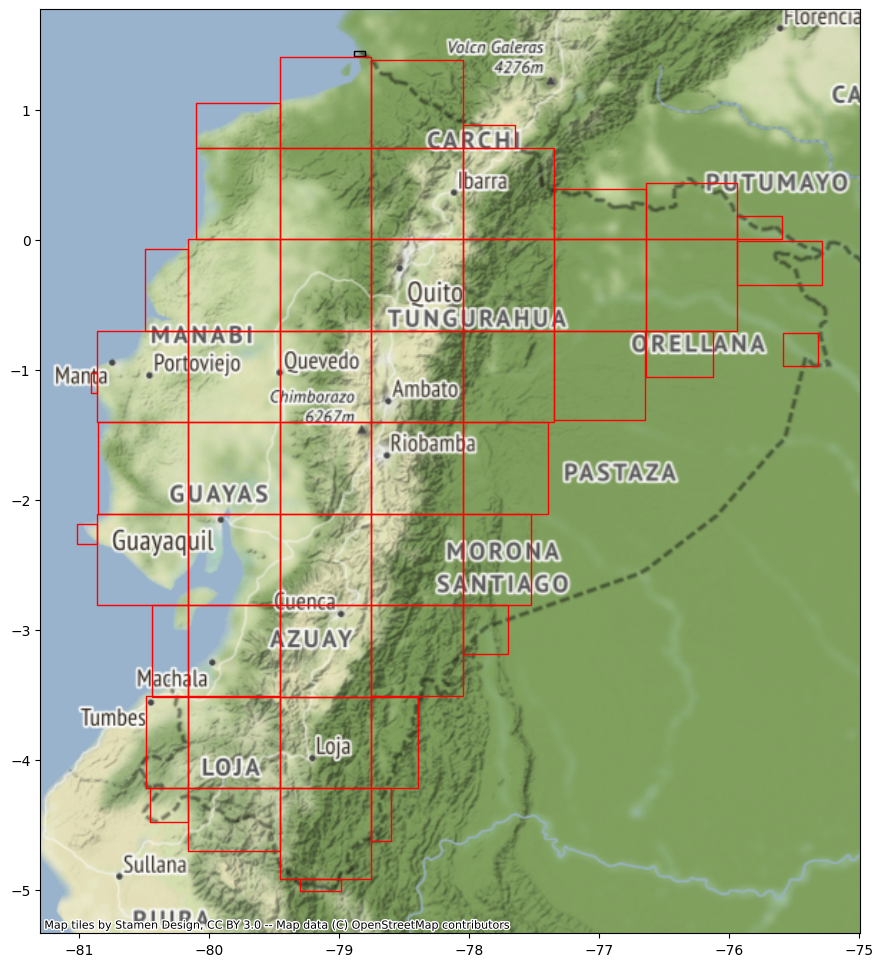

In [10]:
#Ecuador's Continental Territory bounding box
mask_ec = shapely.geometry.box(-81.01024199, -4.988954552, -75.31666317, 1.372664229)

#Plot the partitions
fig, ax = plt.subplots(figsize=(12, 12))
color = ["r" if x else "k" for x in ecuador.spatial_partitions.intersects(mask_ec)]
ecuador.spatial_partitions.plot(facecolor="none", edgecolor=color, ax=ax)
contextily.add_basemap(ax, crs=ecuador.crs.to_string())

In [11]:
#Read and format Shape Files
labota_shp = gpd.read_file("/content/drive/MyDrive/Diversa/LaBota.shp")
if labota_shp.crs is None:
    labota_shp.crs = 'epsg:32717'
labota_shp = labota_shp.to_crs('epsg:4326')
# Extract the bounding box of the labota_shp
bbox_bota = labota_shp.total_bounds
polygon_bota = Polygon([(bbox_bota[0], bbox_bota[1]), (bbox_bota[0], bbox_bota[3]), (bbox_bota[2], bbox_bota[3]), (bbox_bota[2], bbox_bota[1])])
# Get the centroid of the bounding box
centroid_bota = polygon_bota.centroid
# Print the centroid coordinates
print(centroid_bota.x, centroid_bota.y)

toctiuco_shp = gpd.read_file("/content/drive/MyDrive/Diversa/Toctiuco.shp")
if toctiuco_shp.crs is None:
    toctiuco_shp.crs = 'epsg:32717'
toctiuco_shp = toctiuco_shp.to_crs('epsg:4326')
# Extract the bounding box of the labota_shp
bbox_toctiuco = toctiuco_shp.total_bounds
polygon_toctiuco = Polygon([(bbox_toctiuco[0], bbox_toctiuco[1]), (bbox_toctiuco[0], bbox_toctiuco[3]), (bbox_toctiuco[2], bbox_toctiuco[3]), (bbox_toctiuco[2], bbox_toctiuco[1])])
# Get the centroid of the bounding box
centroid_toctiuco = polygon_toctiuco.centroid
# Print the centroid coordinates
print(centroid_toctiuco.x, centroid_toctiuco.y)
#Bounding boxes
mask_bota = shapely.geometry.box(-78.4637712113, -0.1217830052, -78.4495483426, -0.1120515907)
mask_toc = shapely.geometry.box(-78.5252971684, -0.2152934376, -78.5199717432, -0.2080837087)
subset_bota = ecuador.clip(mask_bota).compute()
subset_toc = ecuador.clip(mask_toc).compute()

-78.45956887257326 -0.11562405304648693
-78.52568864705847 -0.20985476660321467


In [13]:
# Spatial join the GeoDataFrame and the shapefile
LaBota_Buildings = gpd.sjoin(subset_bota, labota_shp, predicate='intersects')
LaBota_Buildings = LaBota_Buildings[['OBJECTID', 'DPA_MANZAN' , 'DENSIDAD', 'AREA', 'geometry', 'index_right', 'quadkey']]
Toctiuco_Buildings = gpd.sjoin(subset_toc, toctiuco_shp, predicate='intersects')
Toctiuco_Buildings = Toctiuco_Buildings[['OBJECTID', 'DPA_MANZAN' , 'DENSIDAD', 'AREA', 'geometry', 'index_right', 'quadkey']]

In [15]:
# Maps boundaries
def bounding_box_mercator(lat, lon, radius):
    # Define coordinate systems
    wgs84 = CRS("EPSG:4326")  # WGS84
    web_mercator = CRS("EPSG:3857")  # Web Mercator

    # Define transformer
    transformer = Transformer.from_crs(wgs84, web_mercator)

    # Transform lat lon to Web Mercator
    lon_mercator, lat_mercator = transformer.transform(lat, lon)

    # Add/subtract the radius from the projected point
    min_lat = lat_mercator - radius
    max_lat = lat_mercator + radius
    min_lon = lon_mercator - radius
    max_lon = lon_mercator + radius

    return min_lat, min_lon, max_lat, max_lon

# La bota
lat_centroid_bota = centroid_bota.y
lon_centroid_bota = centroid_bota.x
# Toctiuco
lat_centroid_toctiuco = centroid_toctiuco.y
lon_centroid_toctiuco = centroid_toctiuco.x
# Radius
radius = 1250  # meters

min_lat_BOTA, min_lon_BOTA, max_lat_BOTA, max_lon_BOTA = bounding_box_mercator(lat_centroid_bota, lon_centroid_bota, radius)
min_lat_TOC, min_lon_TOC, max_lat_TOC, max_lon_TOC = bounding_box_mercator(lat_centroid_toctiuco, lon_centroid_toctiuco, radius)

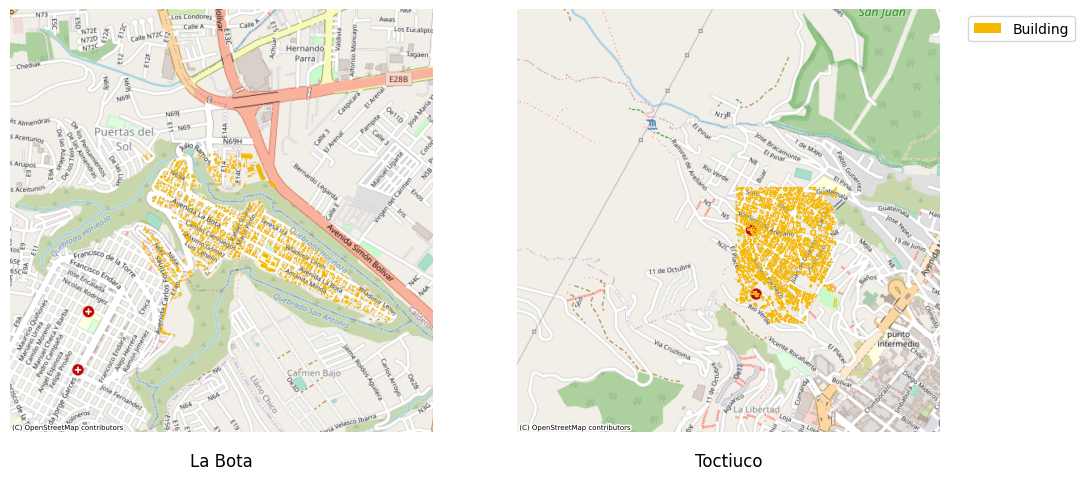

In [16]:
# Convert geodataframe to Web Mercator (epsg:3857)
LaBota_Buildings.crs = "EPSG:4326"
LaBota_Buildings2 = LaBota_Buildings.to_crs(epsg=3857)

Toctiuco_Buildings.crs = "EPSG:4326"
Toctiuco_Buildings2 = Toctiuco_Buildings.to_crs(epsg=3857)
# Define the transformer from WGS84 to Web Mercator
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Create the first subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1
ax = axs[0]

# Set the x and y axis limits
ax.set_xlim(min_lon_BOTA, max_lon_BOTA)
ax.set_ylim(min_lat_BOTA, max_lat_BOTA)

# Plot the data (only boundaries in this case)
LaBota_Buildings2.plot(ax=ax, color='#F5B700', linewidth=0.7)

# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('La Bota', loc='center', y=-0.1)

ax = axs[1]

# Set the x and y axis limits
ax.set_xlim(min_lon_TOC, max_lon_TOC)
ax.set_ylim(min_lat_TOC, max_lat_TOC)

# Plot the data (only boundaries in this case)
Toctiuco_Buildings2.boundary.plot(ax=ax, color='#F5B700', linewidth=0.7)

# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('Toctiuco', loc='center', y=-0.1)

# Create a list of legend elements
legend_elements = [
    Patch(facecolor='#F5B700', edgecolor='none', label='Building')
]

# Create the legend
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

In [17]:
# Save the figure in 300 dpi with tiff format
fig.savefig('/content/drive/MyDrive/Diversa/figures/BuildingsFootprint.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('/content/drive/MyDrive/Diversa/figures/BuildingsFootprint.jpg', dpi=300, format='jpeg', bbox_inches='tight')